In [1]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_csv('for_time_series_VAR_model.csv')

In [4]:
#df_Pedestrian=df[['Total_Pedestrian_Count_per_day','Date']]

#Augmented Dickey Fuller test (ADF Test)
result = adfuller(df['Total_Pedestrian_Count_per_day'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.1340124129475764
p-value: 0.23105973610232755
Critial Values:
   1%, -3.4334544462214303
Critial Values:
   5%, -2.8629114161159666
Critial Values:
   10%, -2.5675000767713883


In [5]:
# Splitting the dataset into train & test subsets
df=df[['Rainfall amount (millimetres)',
      'Minimum temperature (Degree C)','Maximum temperature (Degree C)',
      'Daily global solar exposure (MJ/m*m)','Total_Pedestrian_Count_per_day','Date','Covid Restrictions']]
df['Date'] = pd.to_datetime(df['Date'])
df.drop(index=(df.loc[(df['Covid Restrictions']=='Restrictions')].index))
df.index = df.Date
df = df.drop(['Date','Covid Restrictions'],axis=1)

df_norm=df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

n_obs = 10
df_train, df_test = df_norm[:-n_obs], df_norm[-n_obs:]

In [6]:
# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in df_train.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
df_differenced=df_train
df_differenced['Total_Pedestrian_Count_per_day']=np.log(df_differenced['Total_Pedestrian_Count_per_day'])
df_differenced['Daily global solar exposure (MJ/m*m)']=np.log(df_differenced['Daily global solar exposure (MJ/m*m)'])
df_differenced=df_differenced[~df_differenced.isin([np.nan, np.inf, -np.inf]).any(1)].dropna()
# Running the ADF test once again to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
df_differenced['Total_Pedestrian_Count_per_day']=df_differenced['Total_Pedestrian_Count_per_day'].diff()
df_differenced['Daily global solar exposure (MJ/m*m)']=df_differenced['Daily global solar exposure (MJ/m*m)'].diff()
df_differenced=df_differenced[~df_differenced.isin([np.nan, np.inf, -np.inf]).any(1)].dropna()

# Running the ADF test once again to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')



Column:  Rainfall amount (millimetres)
--------------------------------------
Test Statistic           -24.337858
p-value                    0.000000
# Lags                     2.000000
# Observations          2119.000000
Critical Value (1%)       -3.433440
Critical Value (5%)       -2.862905
Critical Value (10%)      -2.567497
dtype: float64

Series is Stationary


Column:  Minimum temperature (Degree C)
--------------------------------------
Test Statistic            -3.391451
p-value                    0.011254
# Lags                    16.000000
# Observations          2105.000000
Critical Value (1%)       -3.433460
Critical Value (5%)       -2.862914
Critical Value (10%)      -2.567501
dtype: float64

Series is Stationary


Column:  Maximum temperature (Degree C)
--------------------------------------
Test Statistic            -2.792574
p-value                    0.059342
# Lags                    24.000000
# Observations          2097.000000
Critical Value (1%)       -3.433472
Cr

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Test Statistic            -3.378342
p-value                    0.011720
# Lags                    16.000000
# Observations          2103.000000
Critical Value (1%)       -3.433463
Critical Value (5%)       -2.862915
Critical Value (10%)      -2.567502
dtype: float64

Series is Stationary


Column:  Maximum temperature (Degree C)
--------------------------------------
Test Statistic            -2.775584
p-value                    0.061847
# Lags                    24.000000
# Observations          2095.000000
Critical Value (1%)       -3.433475
Critical Value (5%)       -2.862921
Critical Value (10%)      -2.567505
dtype: float64

Series is Non-Stationary


Column:  Daily global solar exposure (MJ/m*m)
--------------------------------------
Test Statistic            -2.667422
p-value                    0.079847
# Lags                    18.000000
# Observations          2101.000000
Critical Value (1%)       -3.433466
Critical Value (5%)       -2.862917
Critical Value (10%)      -2.56750

In [7]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
results = model.fit(maxlags =15, ic = 'aic')

forecast_values = results.forecast(results.y, steps=len(df_test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [8]:
forecast_values=pd.DataFrame(forecast_values,index=df_test.index,columns=['Rainfall amount (millimetres)',
      'Minimum temperature (Degree C)','Maximum temperature (Degree C)',
      'Daily global solar exposure (MJ/m*m)','Total_Pedestrian_Count_per_day'])

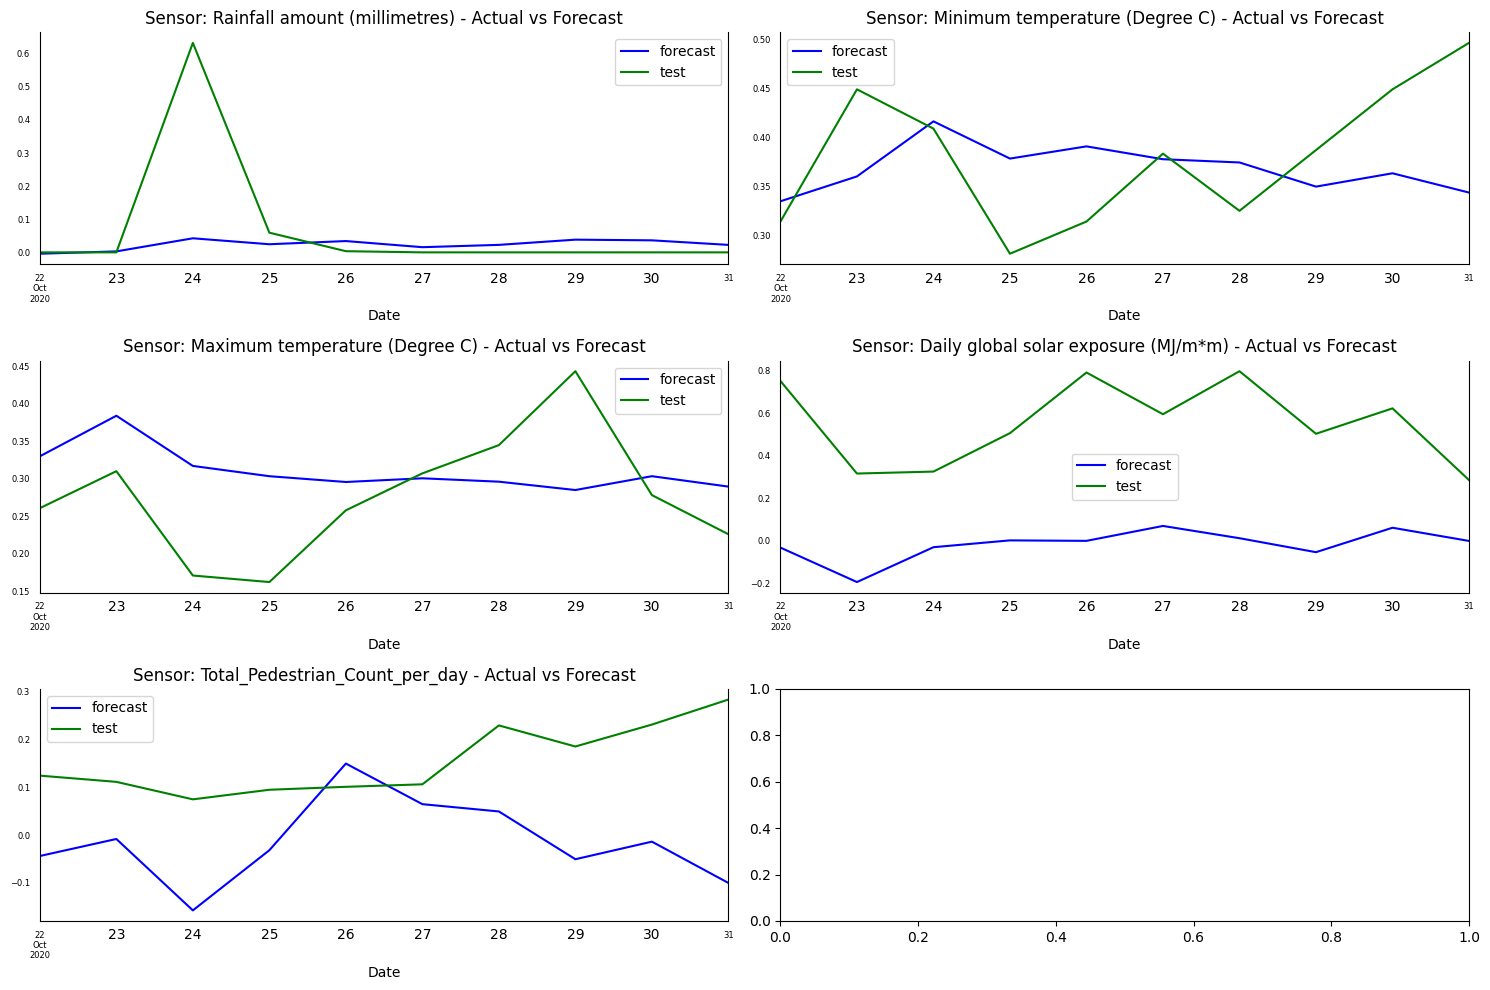

In [9]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = 3, ncols = 2, dpi = 100, figsize = (15,10))

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    forecast_values[col].plot(color = 'b', legend = True,label="forecast",ax = ax).autoscale(axis =' x',tight = True)
    df_test[col].plot(color = 'g', legend = True,label="test",ax = ax)

    ax.set_title('Sensor: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Apr, 2021
Time:                     08:43:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -19.5488
Nobs:                     2110.00    HQIC:                  -19.9395
Log likelihood:           6534.49    FPE:                1.74734e-09
AIC:                     -20.1652    Det(Omega_mle):     1.56872e-09
--------------------------------------------------------------------
Results for equation Rainfall amount (millimetres)
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                           0.009923         0.006042            1.642           0.101
L1.Rainfall amount (millimetres)       

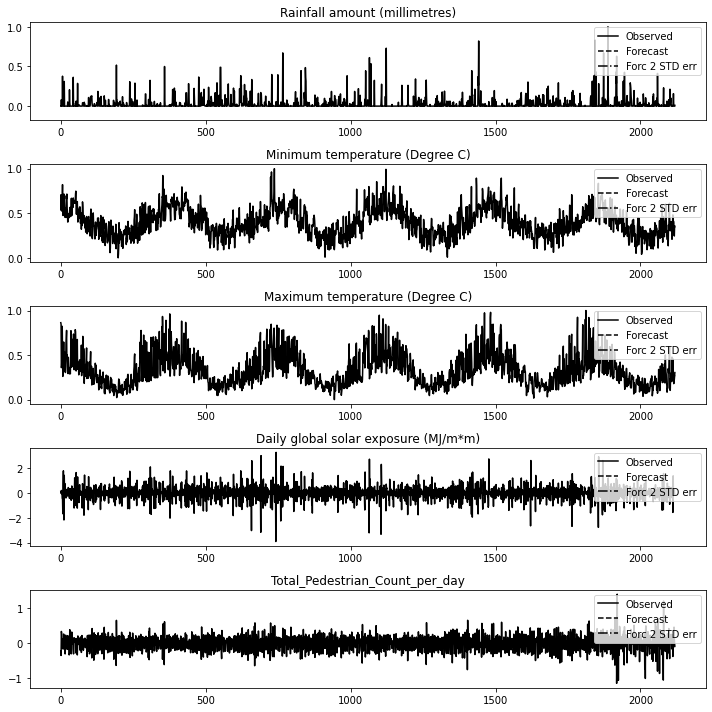

In [10]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
results = model.fit(maxlags = 10, ic = 'aic')
print(results.summary())

# Forecasting for 200 steps ahead
lag_order = results.k_ar
predicted = results.forecast(df_differenced.values[-lag_order:], n_obs)
forecast = pd.DataFrame(predicted, index = df_norm.index[-n_obs:], columns = df_norm.columns)

# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

# Inverting the Differencing Transformation
def invert_transformation(df, df_forecast, second_diff=False):
    for col in df.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (df_test[col].iloc[-1] - df[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = df[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

forecast_values = invert_transformation(df_train, forecast, second_diff=True)


In [11]:
# MSE
from sklearn.metrics import mean_squared_error
from numpy import asarray as arr
mse = mean_squared_error(df_test, forecast_values)
print('\nMean Squared Error:',mse)


Mean Squared Error: 74.17711110302174
